###New York City Taxi Fare Prediction

## Introduction
This project is hosted in partnership with Google Cloud and Coursera. The task is to predict the fare amount for a taxi ride in New York City given the pickup and dropoff locations. The evaluation metric here, as many other regreesion tasks, is the root mean-squared error or RMSE. As usual, I will firstly preprocess the raw data and do the visualization. Afterwards, I will use advanced models to fit the data and do the prediction. 



First of all, I imported all the necessary packages.

In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['font.size']=18

import seaborn as sns
palette = sns.color_palette('Paired',10)

# Any results you write to the current directory are saved as output.

['GCP-Coupons-Instructions.rtf', 'train.csv', 'sample_submission.csv', 'test.csv']


The training data set is very huge. It contains more than 50,000,000 rows. To save memory and time, I read 10 million rows. And I believe this is already enough 
for a prediction job. But obviously there is improvement space here. 

In [36]:
train_df = pd.read_csv('../input/train.csv',nrows=10000000)
train_df = train_df.drop(['key'],axis=1)

train_df.dropna()
train_df.head(5)



,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


As usual, we need to have a first insight of the data. There are only 6 features in the training set. But no doubt we can build more features based on them.
And I already saw some unusual values. For instance, the maximum value of passenger count is over 200, which is obviously too large for a taxi ride. 

In [37]:

train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.000000e+07,1.000000e+07,1.000000e+07,9.999931e+06,9.999931e+06,1.000000e+07
mean,1.133854e+01,-7.250775e+01,3.991934e+01,-7.250897e+01,3.991913e+01,1.684793e+00
std,9.799930e+00,1.299421e+01,9.322539e+00,1.287532e+01,9.237280e+00,1.323423e+00
min,-1.077500e+02,-3.439245e+03,-3.492264e+03,-3.426601e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399139e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396710e+01,4.076712e+01,-7.396367e+01,4.076810e+01,2.000000e+00
max,1.273310e+03,3.457626e+03,3.344459e+03,3.457622e+03,3.351403e+03,2.080000e+02


I did the histogram and kernel density plot to look at the distribution of fare amount. Looks like most of them 
are still in a normal range (5-50). But there are some very large values. 

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Distribution of fare amount')

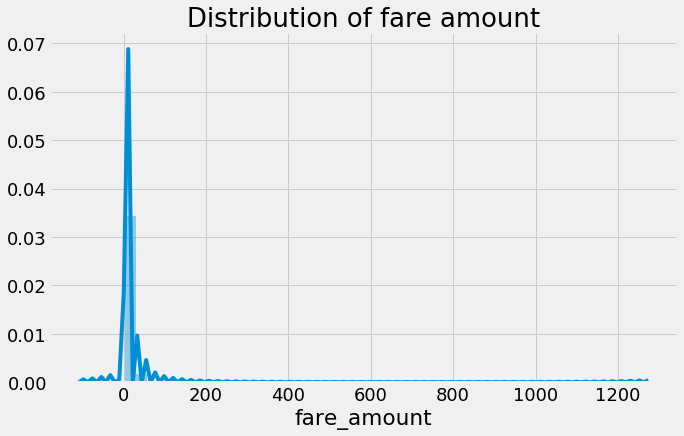

In [38]:
# draw the histogam and kernel density plot of fare amount
plt.figure(figsize = (10, 6))
sns.distplot(train_df['fare_amount'])
plt.title('Distribution of fare amount')

From its website, we know the base price of New York City Taxi is 2.50,
Here I restricetd the feature "fare_amount", which is also our prediction target, to a range from 2.50 to 100.
Obviously, the fare amount should be positive and larger than the base price. 
For the upper limit, I believe a number larger than 100 is way too much high for a taxi ride. 
The choose of this upper limit is arbitrary but reasonable. 


In [39]:
negative = train_df[train_df['fare_amount']<0]
print(len(negative))
zero_fare = train_df[train_df['fare_amount']==0]
print(len(zero_fare))
Less_than_base = train_df[(train_df['fare_amount']>0) & (train_df['fare_amount']<2.5)]
print(len(Less_than_base))
large_fare = train_df[train_df['fare_amount']>=100]
print(len(large_fare))

420
269
152
4190


In [40]:
train_df = train_df[(train_df['fare_amount']>=2.5) & (train_df['fare_amount']<100 )]

In [41]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9.994969e+06,9.994969e+06,9.994969e+06,9.994900e+06,9.994900e+06,9.994969e+06
mean,1.128700e+01,-7.251089e+01,3.992109e+01,-7.251281e+01,3.992125e+01,1.684933e+00
std,9.390138e+00,1.298667e+01,9.320047e+00,1.286569e+01,9.233898e+00,1.323574e+00
min,2.500000e+00,-3.439245e+03,-3.492264e+03,-3.426601e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073492e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076712e+01,-7.396369e+01,4.076810e+01,2.000000e+00
max,9.999000e+01,3.457626e+03,3.344459e+03,3.457622e+03,3.351403e+03,2.080000e+02


I put all the fare amount values into bins with a increment of 5. It can be seen that a large portion of fare amount is in the range from 5 to 10. 
Overall, it exhibits a long-tailed distribution shape. 

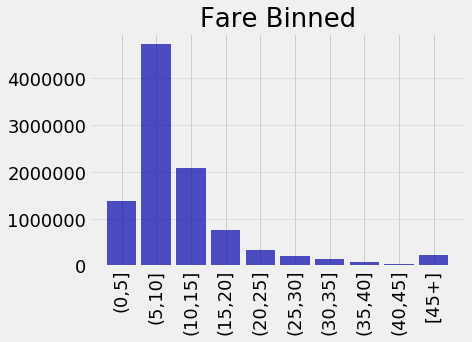

In [42]:
bins=[0,5,10,15,20,25,30,35,40,45,50]
data=np.array(train_df['fare_amount'])
n,bins,patches = plt.hist(np.clip(data,bins[0],bins[-1]),bins=bins,color='#0504aa',alpha=0.7,rwidth=0.85)
plt.grid(axis='y',alpha=0.5)
plt.xticks([2.5,7.5,12.5,17.5,22.5,27.5,32.5,37.5,42.5,47.5],('(0,5]','(5,10]','(10,15]','(15,20]','(20,25]','(25,30]','(30,35]','(35,40]','(40,45]','[45+]'),
           rotation=90)
#plt.xlabel('Fare amount')
#plt.ylabel('Frequency')
plt.title('Fare Binned')
plt.show()

I also checked the distribution of passenger number. Most of them are in a reasonable range(1-6). But large values also appeared. 
So I restricted this feature in the range from 1 to 6, which is for a normal taxi vehicle.

[Text(0,0,'0'),
 Text(0,0,'1'),
 Text(0,0,'2'),
 Text(0,0,'3'),
 Text(0,0,'4'),
 Text(0,0,'5'),
 Text(0,0,'6'),
 Text(0,0,'7'),
 Text(0,0,'9'),
 Text(0,0,'49'),
 Text(0,0,'51'),
 Text(0,0,'129'),
 Text(0,0,'208')]

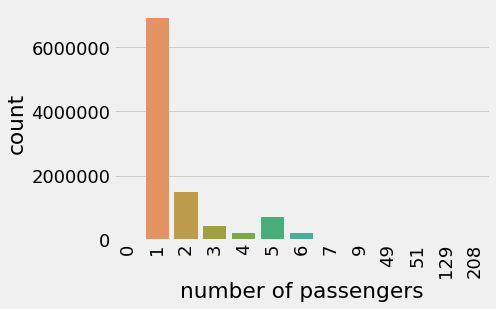

In [43]:
ax = sns.countplot(x="passenger_count",data=train_df,)
ax.set(xlabel='number of passengers')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [44]:
train_df = train_df[(train_df['passenger_count']<=6) & (train_df['passenger_count']>0)]

As this research is for the taxi fare in New York City. After checking the map, we decided to restrict the longitude and latitude to a 
relative wide range. The longitude is from -78° to -70°, and the latitude is from 37° to 45° .

In [45]:
train_df = train_df[(train_df['pickup_longitude']>-78)&(train_df['dropoff_longitude']>-78)
                   &(train_df['pickup_longitude']<-70)&(train_df['dropoff_longitude']<-70)
                   &(train_df['pickup_latitude']>37) & (train_df['dropoff_latitude']>37)
                   &(train_df['pickup_latitude']<45) & (train_df['dropoff_latitude']<45)]


The figure below shows the scatter plot of all the longitude and latitude values of all the pickup and dropoff positions. 
From the graph, you may find most of them are aggregrating together, where I believe is downtown area of New York City.
But there are still some places that are far away from downtown, which might lead to a high ride fare.

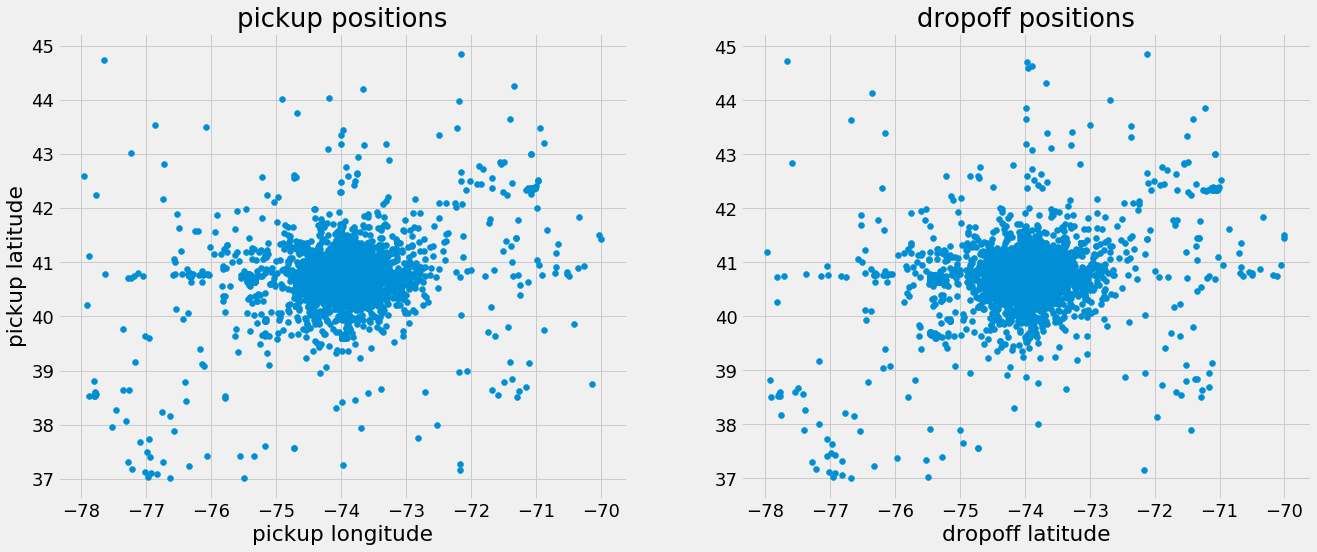

In [46]:
fig,axes=plt.subplots(1,2,figsize=(20,8))
axes[0].scatter(train_df['pickup_longitude'],train_df['pickup_latitude'])
axes[1].scatter(train_df['dropoff_longitude'],train_df['dropoff_latitude'])
axes[0].set_title("pickup positions")
axes[1].set_title("dropoff positions")
axes[0].set_xlabel("pickup longitude")
axes[0].set_ylabel("pickup latitude")
axes[1].set_xlabel("dropoff longitude")
axes[1].set_xlabel("dropoff latitude")
plt.show()



However, when I ploted the fare value as a function of longitude and latitude. It showed that the most expensive cases are in the middle, which is 
the down town area. It might be because of the busy traffic in New York downtown so it will take longer time for a taxi to get to its destination. Another reason 
could be the rate difference in different regions. The taxi rate in downtown might be more expensive than that of other regions.

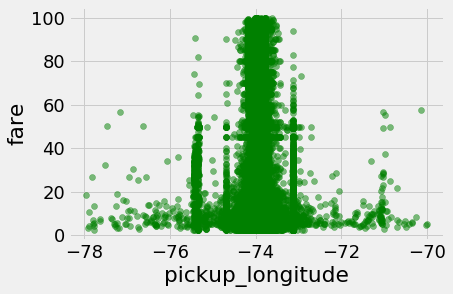

In [47]:
# do some initial plot
import matplotlib.pyplot as plt
X = train_df['pickup_longitude']
y = train_df['fare_amount']
plt.scatter(X,y,c='g',alpha=0.5)
plt.xlabel("pickup_longitude")
plt.ylabel("fare")
plt.show()

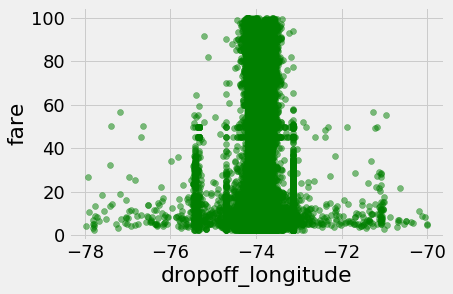

In [48]:
import matplotlib.pyplot as plt
X = train_df['dropoff_longitude']
y = train_df['fare_amount']
plt.scatter(X,y,c='g',alpha=0.5)
plt.xlabel("dropoff_longitude")
plt.ylabel("fare")
plt.show()

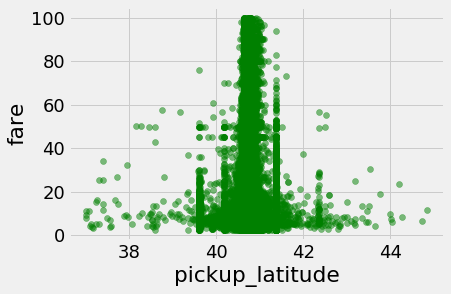

In [49]:
import matplotlib.pyplot as plt
X = train_df['pickup_latitude']
y = train_df['fare_amount']
plt.scatter(X,y,c='g',alpha=0.5)
plt.xlabel("pickup_latitude")
plt.ylabel("fare")
plt.show()

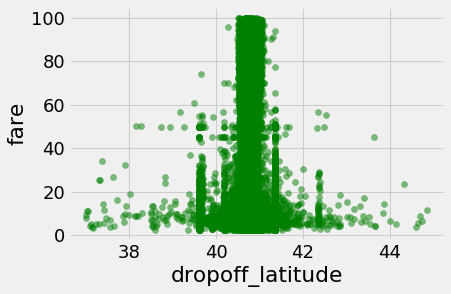

In [50]:
import matplotlib.pyplot as plt
X = train_df['dropoff_latitude']
y = train_df['fare_amount']
plt.scatter(X,y,c='g',alpha=0.5)
plt.xlabel("dropoff_latitude")
plt.ylabel("fare")
plt.show()

I also ploted the fare amount as a function of number of passengers. Not surprisingly, there is no obvious trend between 
these two variables. But there is still some difference in the fare with different number of passengers.

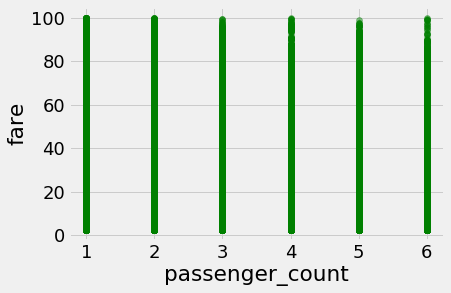

In [51]:
import matplotlib.pyplot as plt
X = train_df['passenger_count']
y = train_df['fare_amount']
plt.scatter(X,y,c='g',alpha=0.5)
plt.xlabel("passenger_count")
plt.ylabel("fare")
plt.show()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


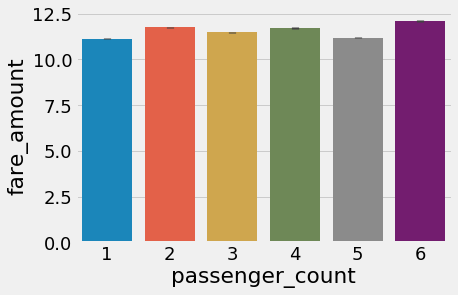

In [53]:
import seaborn as sns
ax = sns.barplot(x='passenger_count',y='fare_amount',data=train_df)

One important feature here is the date and time of each ride. 
In order to deal with this piece of information more conviently, I separated it into different parts. 
Now we have five new features. They are 'year','month','day','hour', and 'weekday'.

In [55]:
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'],
                                             format='%Y-%m-%d %H:%M:%S %Z') 
train_df['year']=train_df['pickup_datetime'].apply(lambda x: x.year)
train_df['month']=train_df['pickup_datetime'].apply(lambda x: x.month)
train_df['day']=train_df['pickup_datetime'].apply(lambda x: x.day)
train_df['hour']=train_df['pickup_datetime'].apply(lambda x: x.hour)
train_df['weekday']=train_df['pickup_datetime'].apply(lambda x: x.weekday())

In [56]:
train_df.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,1
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,3
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,5
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,1


The figure below shows the change of fare amount with 'year'. Very apparently, the more recent rides have higher prices.


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


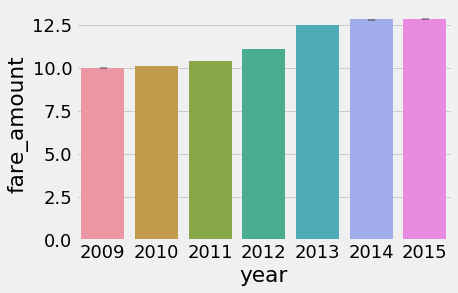

In [57]:

ax = sns.barplot(x='year',y='fare_amount',data=train_df)

The 'month' or the season also have a impact on the fare amount. Spring(April to June) and fall(September to November) have higher ride fares. 
That might be due to good weather conditions in New York City in spring and fall, and therefore the demand of taxi rides increased.  

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


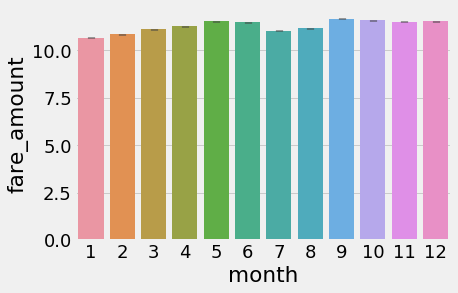

In [58]:

ax = sns.barplot(x='month',y='fare_amount',data=train_df)

Different time in a single day also leads to different fare amount. From the figure below, very late night (4-5 am) has the highest price. 
Another peak appears in afternoon (from 1pm to 4pm). Evening (6pm-8pm) has the lowest ride price. 

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


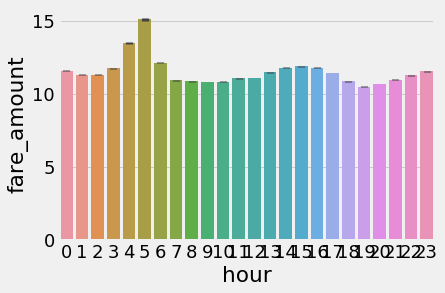

In [59]:

ax = sns.barplot(x='hour',y='fare_amount',data=train_df)

Conversely, weekday doesn't have huge impacts on ride fares. 
But we can still observe slight differences. For instance, saturday has the lowest taxi ride prices. 


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


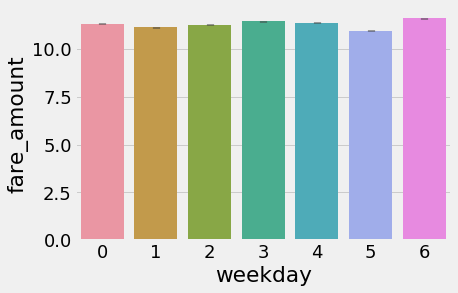

In [60]:

ax = sns.barplot(x='weekday',y='fare_amount',data=train_df)

We will also need to look insight of the test set.
The test set is much smaller. It only has less than 10000 rows. 
We cannot remove rows from it, but we need to do the same feature engineering for it. 

In [61]:
test_df = pd.read_csv('../input/test.csv',index_col='key')
test_df.head(10)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
key,,,,,,
2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1
2012-12-01 21:12:12.0000005,2012-12-01 21:12:12 UTC,-73.960983,40.765547,-73.979177,40.740053,1
2011-10-06 12:10:20.0000001,2011-10-06 12:10:20 UTC,-73.949013,40.773204,-73.959622,40.770893,1
2011-10-06 12:10:20.0000003,2011-10-06 12:10:20 UTC,-73.777282,40.646636,-73.985083,40.759368,1
2011-10-06 12:10:20.0000002,2011-10-06 12:10:20 UTC,-74.014099,40.709638,-73.995106,40.741365,1


In [62]:
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'],
                                             format='%Y-%m-%d %H:%M:%S %Z') 
test_df['year']=test_df['pickup_datetime'].apply(lambda x: x.year)
test_df['month']=test_df['pickup_datetime'].apply(lambda x: x.month)
test_df['day']=test_df['pickup_datetime'].apply(lambda x: x.day)
test_df['hour']=test_df['pickup_datetime'].apply(lambda x: x.hour)
test_df['weekday']=test_df['pickup_datetime'].apply(lambda x: x.weekday())

In [63]:
test_df.head(5)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday
key,,,,,,,,,,,
2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,13,1
2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,13,1
2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,11,5
2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,21,5
2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,21,5


In [64]:
print(train_df.shape)
print(test_df.shape)

(9752996, 12)
(9914, 11)


We saved the processed files here for further operation and prediction.

In [ ]:
train_df.to_csv("processed_train.csv")
test_df.to_csv("processed_test.csv")